# Check 14 site mps states

Objectives:
* Check states created in [this notebook](../save_states/finite_transverse_cluster_save_dmrg_14_site.ipynb). Compare against 14 site ED states.

In [1]:
ED_DATA_DIR = r"../data/transverse_cluster_14_site_dmrg"
MPS_DATA_DIR = r"../data/transverse_cluster_200_site_dmrg"

In [2]:
import h5py
from tenpy.tools import hdf5_io

import os

In [3]:
import sys

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [5]:
import tenpy.linalg.np_conserved as npc

In [6]:
sys.path.append('../')

In [7]:
from SPTOptimization.utils import to_npc_array

In [13]:
import re

# Load data

In [8]:
def split_full_state_legs(full_state_psi):
    dim = full_state_psi.shape

    num_legs = int(np.log2(dim[0]))
    new_labels = [f'p{i}' for i in range(num_legs)]

    full_state_psi.iset_leg_labels(['(' + '.'.join(new_labels) + ')'])
    full_state_psi = full_state_psi.split_legs([0])
    return full_state_psi

In [14]:
p = re.compile(r"^\d_\d\d\.h5$")

In [17]:
loaded_data = list()

for local_file_name in os.listdir(ED_DATA_DIR):
    if p.match(local_file_name):
        f_name = r"{}/{}".format(ED_DATA_DIR, local_file_name, ignore_unknown=False)
        with h5py.File(f_name, 'r') as f:
            data = hdf5_io.load_from_hdf5(f)
            loaded_data.append(data)

In [18]:
b_parameters = sorted(list(d['paramters']['B'] for d in loaded_data))

In [19]:
psi_dict = dict()

In [20]:
for b in b_parameters:
    psi = next(
        d['wavefunction']
        for d in loaded_data
        if d['paramters']['B'] == b
    )
    #psi = split_full_state_legs(psi)
    
    rounded_b = round(b, 1)
    psi_dict[rounded_b] = psi

In [21]:
energies = [t['energy'] for t in loaded_data]

## Load energies from MPS solution

In [16]:
"""
mps_energies = list()

for local_file_name in os.listdir(MPS_DATA_DIR):
    f_name = r"{}/{}".format(MPS_DATA_DIR, local_file_name, ignore_unknown=False)
    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)
        mps_energies.append(data['energy'])
"""

'\nmps_energies = list()\n\nfor local_file_name in os.listdir(MPS_DATA_DIR):\n    f_name = r"{}/{}".format(MPS_DATA_DIR, local_file_name, ignore_unknown=False)\n    with h5py.File(f_name, \'r\') as f:\n        data = hdf5_io.load_from_hdf5(f)\n        mps_energies.append(data[\'energy\'])\n'

# Energies

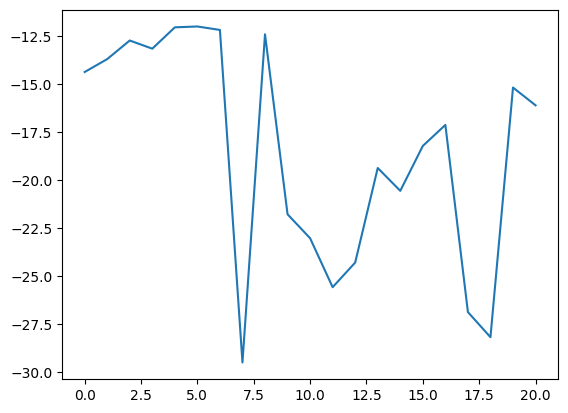

In [22]:
plt.plot(energies)

# String order parameters

In [34]:
def expectation_ops_dict(psi, ops_dict):
    site_indices = sorted(list(ops_dict.keys()))
    first_index, last_index = site_indices[0], site_indices[-1]

    ops = list()

    ops_list = [
        ops_dict.get(i, 'Id')
        for i in range(first_index, last_index+1)
    ]

    out = psi.expectation_value_multi_sites(ops_list, first_index)

    return out

In [35]:
x_string_order_parameter_sites = [3,4,6,8,10,11]

x_string_order_parameter_ops_dict = {
    i: npc_X for i in x_string_order_parameter_sites
}

z_string_order_parameter_ops_dict = {
    3: npc_Z,
    4: npc_X,
    6: npc_X,
    8: npc_X,
    10: npc_X,
    11: npc_Z
}


In [36]:
x_string_order_parameters = [
    expectation_ops_dict(psi, x_string_order_parameter_ops_dict)
    for psi in psi_dict.values()
]

In [37]:
z_string_order_parameters = [
    expectation_ops_dict(psi, z_string_order_parameter_ops_dict)
    for psi in psi_dict.values()
]

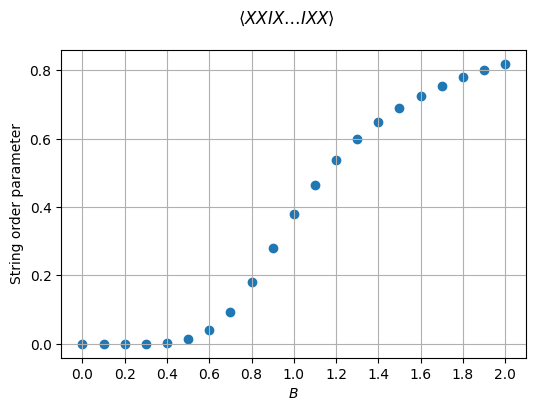

In [39]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.scatter(b_parameters, x_string_order_parameters)

ax.xaxis.set_major_locator(
    matplotlib.ticker.MultipleLocator(0.2)
)

ax.grid()

ax.set_xlabel('$B$')
ax.set_ylabel('String order parameter')

fig.suptitle(r'$\langle XXIX\ldots IXX\rangle$')

fig.savefig(r'plots/ed_X_string_order_parameter.png', dpi=200)

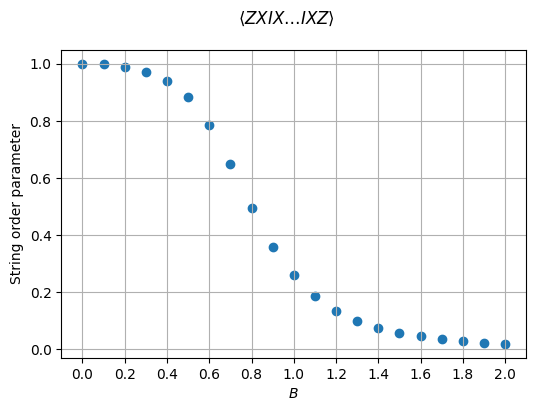

In [40]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.scatter(b_parameters, z_string_order_parameters)

ax.xaxis.set_major_locator(
    matplotlib.ticker.MultipleLocator(0.2)
)

ax.grid()

ax.set_xlabel('$B$')
ax.set_ylabel('String order parameter')

fig.suptitle(r'$\langle ZXIX\ldots IXZ\rangle$')

fig.savefig(r'plots/ed_Z_string_order_parameter.png', dpi=200)

# Conclusions
String order parameters match ED calculations.